In [22]:
import pandas as pd
import numpy as np
import json
import gensim
from nltk.tokenize import word_tokenize
import fasttext
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
import plotly.express as px

import matplotlib.pyplot as plt

In [31]:
with open('../data/genmymodel_uml_extracted_metadata_annotated.json') as json_file:
    data = json.load(json_file)

    english_data = {
        file: data[file]
        for file in data.keys()
        if data[file]['lang'] == '__label__en'
    }

In [32]:
# Store all classes and attributes independent of eachother
all_classes = []
all_attrs = []

# Loop over all metadata and append to proper list
for file, metadata in english_data.items():
    if 'classes' in metadata.keys():
        all_classes.append(metadata['classes'])

    if 'attributes' in metadata.keys():
        all_attrs.append(metadata['attributes'])

# Create big dataframe with all values together
flatten = lambda t: [item for sublist in t for item in sublist]
df = pd.DataFrame(list(map(lambda x: [x.strip(), 'class'], flatten(all_classes))) + list(map(lambda x: [x.strip(), 'attribute'], flatten(all_attrs))), columns=['name', 'type'])

In [33]:
df.drop_duplicates(keep=False, inplace=True)

In [5]:
df['tokenized_length'] = df['name'].apply(lambda x: len(word_tokenize(x)))
df = df[df['tokenized_length'] == 1]

In [6]:
PRETRAINED_MODEL_PATH = '../data/lid.176.bin'

model = fasttext.load_model(PRETRAINED_MODEL_PATH)

In [7]:
df['lang'] = df['name'].apply(lambda x: model.predict(x)[0][0])

In [8]:
df = df[df['lang'] == '__label__en']

In [9]:
vocab = [word_tokenize(row) for row in df['name'].to_list()]

In [10]:
df

,name,type,tokenized_length,lang
289,obsever,class,1,__label__en
455,core.php,class,1,__label__en
457,core.model.php,class,1,__label__en
716,fascia,class,1,__label__en
745,maid,class,1,__label__en
...,...,...,...,...
2348354,fghfh,attribute,1,__label__en
2348387,strid,attribute,1,__label__en
2348392,boreholedetail,attribute,1,__label__en
2348442,microposts,attribute,1,__label__en


In [11]:
word2vecSG = gensim.models.Word2Vec(vocab, min_count = 1, window = 5, sg = 1)

In [12]:
filtered_df = pd.concat([df[df['type'] == 'class'][:100], df[df['type'] == 'attribute'][:100]])

In [13]:
filtered_df

,name,type,tokenized_length,lang
289,obsever,class,1,__label__en
455,core.php,class,1,__label__en
457,core.model.php,class,1,__label__en
716,fascia,class,1,__label__en
745,maid,class,1,__label__en
...,...,...,...,...
1052542,remider,attribute,1,__label__en
1053230,taim,attribute,1,__label__en
1053387,corder,attribute,1,__label__en
1053440,tild,attribute,1,__label__en


In [14]:
filtered_df['vector'] = filtered_df['name'].apply(lambda x: word2vecSG.wv.get_vector(x))

In [19]:
filtered_df

,name,type,tokenized_length,lang,vector
0,obsever,class,1,__label__en,"[-0.0010219195, -0.0011943039, 0.003056583, 0...."
1,maxplayer,attribute,1,__label__en,"[-0.0026133442, -0.0012201075, -0.0007959332, ..."
2,core.php,class,1,__label__en,"[0.0033512455, -0.0031765345, -0.0005415987, 0..."
3,cler,attribute,1,__label__en,"[-0.003280134, 0.0005791902, 0.000261293, -0.0..."
4,core.model.php,class,1,__label__en,"[-0.002903999, 0.00085377705, 0.0023411142, 0...."
...,...,...,...,...,...
195,corder,attribute,1,__label__en,"[-0.0016915371, 0.0006388972, 0.002362722, -0...."
196,hnd,class,1,__label__en,"[-0.0045872726, 0.0030157159, -0.004946031, 0...."
197,tild,attribute,1,__label__en,"[-0.0043456675, 0.00040812924, -5.1368293e-05,..."
198,bsc,class,1,__label__en,"[0.00400598, -0.0023212577, -0.0033433707, -0...."


In [27]:
vectors = filtered_df['vector'].to_list()
pca = PCA(n_components=3)
pcas = pca.fit_transform(vectors)
pca_df = pd.DataFrame(data = pcas, columns = ['pc1', 'pc2', 'pc3'])
pca_df['cluster_label'] = filtered_df['type'].tolist()
pca_df.sort_values(by='cluster_label', inplace=True)

fig = px.scatter_3d(pca_df, x='pc1', y='pc2', z='pc3', color='cluster_label', size_max=0.1, opacity=0.7)
fig.update_traces(marker=dict(size=3))

In [29]:
pca.explained_variance_

array([2.43643826e-05, 2.34790544e-05, 2.28350578e-05])

In [30]:
filtered_df['vector']

0      [-0.0010219195, -0.0011943039, 0.003056583, 0....
1      [-0.0026133442, -0.0012201075, -0.0007959332, ...
2      [0.0033512455, -0.0031765345, -0.0005415987, 0...
3      [-0.003280134, 0.0005791902, 0.000261293, -0.0...
4      [-0.002903999, 0.00085377705, 0.0023411142, 0....
                             ...                        
195    [-0.0016915371, 0.0006388972, 0.002362722, -0....
196    [-0.0045872726, 0.0030157159, -0.004946031, 0....
197    [-0.0043456675, 0.00040812924, -5.1368293e-05,...
198    [0.00400598, -0.0023212577, -0.0033433707, -0....
199    [0.0018680986, -0.0036427313, 0.002984859, -0....
Name: vector, Length: 200, dtype: object

In [15]:
alternated = []

for index in range(int(len(filtered_df) / 2)):
    alternated.append(filtered_df[filtered_df['type'] == 'class'].iloc[index].values)
    alternated.append(filtered_df[filtered_df['type'] == 'attribute'].iloc[index].values) 

column_names = filtered_df.columns
filtered_df = pd.DataFrame(alternated, columns = column_names)

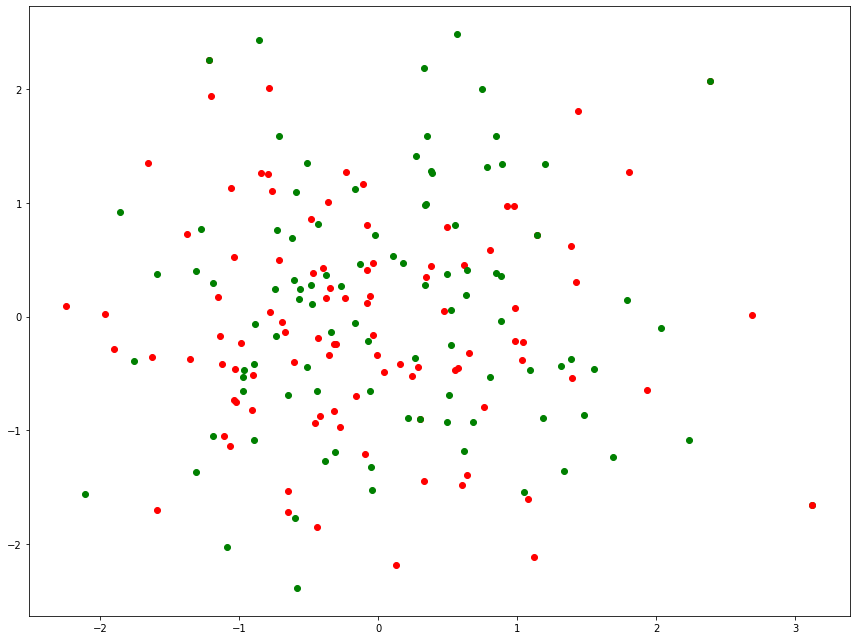

In [16]:
# define the words to visualize

topterms = {name: 1 for name in filtered_df['name'].to_list()}


vectors = filtered_df['vector'].to_list()
#tsne = TSNE(n_components=2, random_state=0)
#vectors2d = tsne.fit_transform(vectors)
pca = PCA(n_components=2, whiten=True)
vectors2d = pca.fit(vectors).transform(vectors)
#print(vectors2d)
plt.figure(figsize=(12,9))
alternate = True
first = True # color alternation to divide given groups
for point, word in zip(vectors2d , topterms):
    # plot points
    plt.scatter(point[0], point[1], c='r' if first else 'g')
    # plot word annotations
    plt.annotate(
        '',
        xy = (point[0], point[1]),
        xytext = (-7, -6) if first else (7, -6),
        textcoords = 'offset points',
        ha = 'right' if first else 'left',
        va = 'bottom',
        size = "x-large"
    )
    first = not first if alternate else first

plt.tight_layout()
plt.show()



In [34]:
model = gensim.models.FastText(vocab, min_count=1)

In [35]:
filtered_df['vector'] = filtered_df['name'].apply(lambda x: model.wv.get_vector(x))

In [36]:
vectors = filtered_df['vector'].to_list()
pca = PCA(n_components=3)
pcas = pca.fit_transform(vectors)
pca_df = pd.DataFrame(data = pcas, columns = ['pc1', 'pc2', 'pc3'])
pca_df['cluster_label'] = filtered_df['type'].tolist()
pca_df.sort_values(by='cluster_label', inplace=True)

fig = px.scatter_3d(pca_df, x='pc1', y='pc2', z='pc3', color='cluster_label', size_max=0.1, opacity=0.7)
fig.update_traces(marker=dict(size=3))

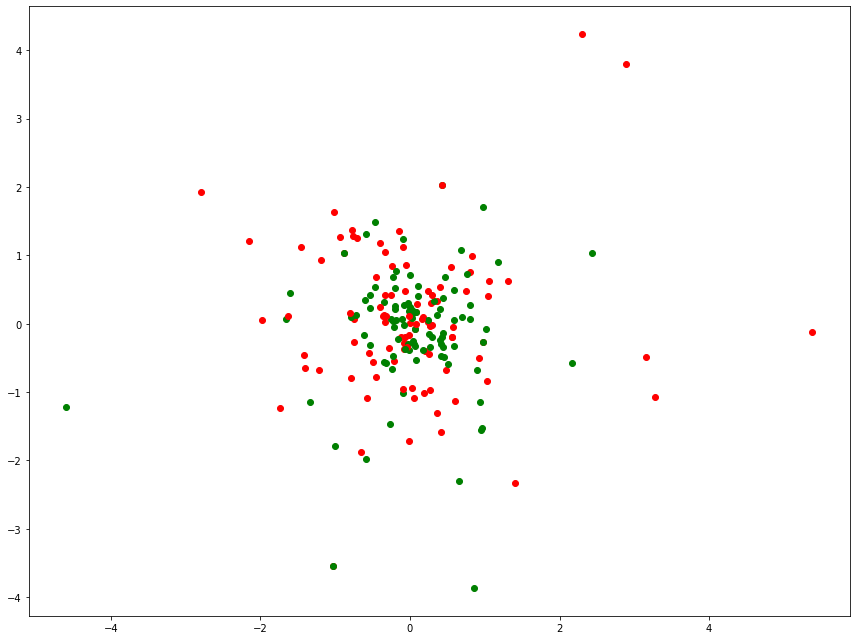

In [37]:
# define the words to visualize

topterms = {name: 1 for name in filtered_df['name'].to_list()}


vectors = filtered_df['vector'].to_list()
#tsne = TSNE(n_components=2, random_state=0)
#vectors2d = tsne.fit_transform(vectors)
pca = PCA(n_components=2, whiten=True)
vectors2d = pca.fit(vectors).transform(vectors)
#print(vectors2d)
plt.figure(figsize=(12,9))
alternate = True
first = True # color alternation to divide given groups
for point, word in zip(vectors2d , topterms):
    # plot points
    plt.scatter(point[0], point[1], c='r' if first else 'g')
    # plot word annotations
    plt.annotate(
        '',
        xy = (point[0], point[1]),
        xytext = (-7, -6) if first else (7, -6),
        textcoords = 'offset points',
        ha = 'right' if first else 'left',
        va = 'bottom',
        size = "x-large"
    )
    first = not first if alternate else first

plt.tight_layout()
plt.show()

